In [243]:
import pandas as pd
import seaborn as sns

In [355]:
df = pd.read_csv('/Users/Flo/spiced/data/2/train.csv')

In [356]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [358]:
df.shape

(891, 12)

In [359]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [360]:
# Drop the useless col and transform the strings  --> a "bold move"(?) but it also seems common sense and allow me to perform a better EDA.
# Drop Name, Ticket, and Cabin (Might have been interesting but too many missing values and difficult to work with cause string)

df.drop(['Name','Ticket','Cabin'], axis=1,inplace=True)

In [361]:
# We should be able to improve our model by feature engineering Age and Embarked

#'Embarked' correspond to the Port of Embarkation which is in order, Southampton (S), Cherbourg (C) and Queenstown (Q) / or Cobh for our Irish friends (Q). 

cities = {'S':1,'C':2,'Q':3}
df['Embarked'] =df['Embarked'].replace(cities)


In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 62.8+ KB


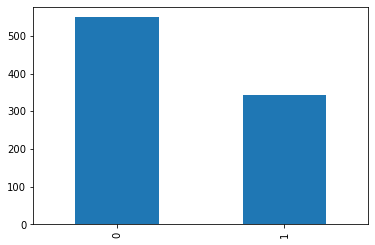

In [363]:
#Quickly ploting how many survived
df['Survived'].value_counts().plot.bar()

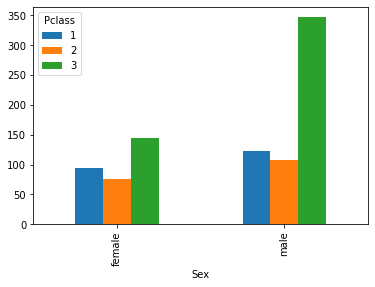

In [364]:
#Plot the amount of passenger per Sex and Class
df.groupby(['Sex','Pclass'])['PassengerId'].count().unstack().plot.bar()

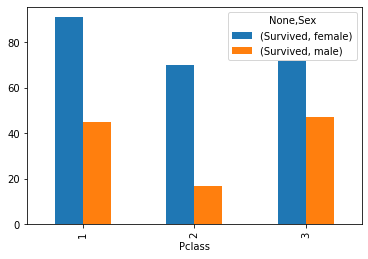

In [365]:
#Plot the survivors per Sex and Class
df.groupby(['Pclass','Sex'])[['Survived']].sum().unstack().plot.bar()

#It seems like women survived much more often than men

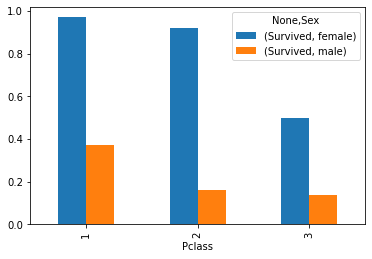

In [366]:
#Let's look into that with a survival ratio

Sex_Class= df.groupby(['Pclass','Sex'])[['Survived']].sum().unstack()
Sex_Class_sum = df.groupby(['Pclass','Sex'])[['Survived']].count().unstack()

Sex_Class_Survive_chance = round(Sex_Class / Sex_Class_sum,2)
Sex_Class_Survive_chance.plot.bar()

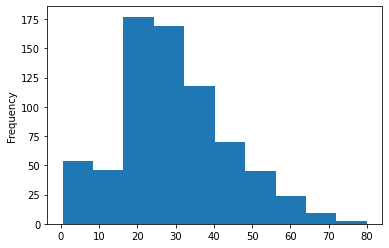

In [367]:
#Plot age
df['Age'].plot.hist()

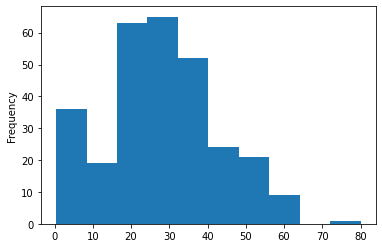

In [368]:
#Plot Survivors age
test = df['Age'].where(df['Survived'] == 1).dropna().plot.hist()

#The age didn't seems to have much impact on the survival chance, except for the young children maybe :/

In [369]:
# Just for fun, let's try to make a prediction based on the survival chances from Sex and Class
survival_prediction_rate = abs(0.5 - Sex_Class_Survive_chance)+0.5
correct_prediction= Sex_Class_sum * survival_prediction_rate
basic_prediction_score = correct_prediction.unstack().sum() / 891
basic_prediction_score

0.7846240179573511

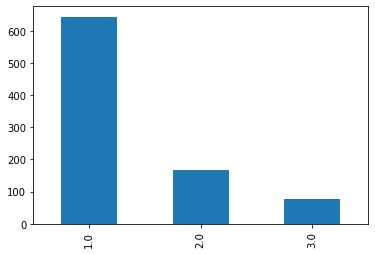

In [370]:
#Graph 'Embarked'
df['Embarked'].value_counts().plot.bar()


In [371]:
#I will already transform Sex to int to be able to run a pairplot
#Transform Sex to a int
df['Sex'] = pd.factorize(df['Sex'])[0]

# ML 



1. Define goals
2. Get data
3. Train test split
4. EDA train data
5. Benchmark: Baseline performance check (run first ML) 
6. Feature --> like bin age
*ML is not able to work on string!

In [372]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer

In [373]:
# Let's try to run a basic Logistic Regression, my goal being to predict if a passenger survived or not. 

In [374]:
# I first need to fill the na for Age and Embarked
imputer_age = SimpleImputer(strategy='median')
imputer_embarked = SimpleImputer(strategy='median')

df['Age'] = imputer_age.fit_transform(df[['Age']])
df['Embarked'] = imputer_embarked.fit_transform(df[['Embarked']])

In [375]:
# Define X 
X = df[['Pclass','Sex','Age','Fare','Embarked']]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   Fare      891 non-null    float64
 4   Embarked  891 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.9 KB


In [376]:
# Define y
y = df['Survived']

In [377]:
# I will still split the data into a training set and a test set, to simulate a real case
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=42)

In [378]:
# Create model
m = LogisticRegression(random_state=42)

In [379]:
# Train/fit model
m.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [380]:
# Use the model to make predictions on the seen data
y_pred_train = m.predict(X_train)

In [381]:
# Model accuracy

round(m.score(X_train, y_train), 2)

0.79

In [382]:
#Let's look at the prediction quality

# accuracy
accuracy_score(y_true=y_train,y_pred=y_pred_train)

0.7919161676646707

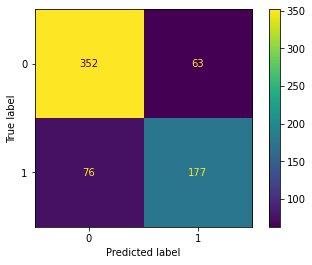

In [383]:
plot_confusion_matrix(estimator=m,
                     X=X_train,
                     y_true=y_train)

# It seems like the model as a shared amount of false positives and false negatives

In [384]:
#Let's make it simpler with a function

def classifiers(y_train, y_pred_train, x):
    precision = round(precision_score(y_train, y_pred_train,pos_label= x), 2)
    recall = round(recall_score(y_train, y_pred_train, pos_label= x),2)
    f1 = round(f1_score(y_train, y_pred_train, pos_label= x),2)

    print('precision, recall, f1')
    return precision, recall, f1

classifiers(y_train, y_pred_train,1)

#We see that the model is overall better to predict none survivors than survivors

precision, recall, f1


(0.74, 0.7, 0.72)

In [336]:
# We should be able to improve our model by feature engineering Age and Embarked

#'Embarked' correspond to the Port of Embarkation which is in order, Southampton (S), Cherbourg (C) and Queenstown (Q) / or Cobh for our Irish friends (Q). 
# Although there is an order, let's try to use One hot encoding 
df['Embarked'].fillna(0)

column_transformer = ColumnTransformer([
    ('Embarked_encoder', OneHotEncoder(drop='if_binary'), ['Embarked']) # Creates a dummy column (0 or 1)
])

#one_hot_Embarked = pd.get_dummies(df['Embarked'])

#column_transformer.fit_transform(X_train)

pd.DataFrame(column_transformer.fit_transform(X_train), columns=trans_columns)



ValueError: A given column is not a column of the dataframe

In [385]:
# Bin age based on 3 categories
bins = [-1, 15, 60, 100]
age_labels = [1, 2, 3]
X_train['Age'] = pd.cut(X_train["Age"], bins, labels = age_labels)


In [386]:
#Let see if the model perform better then

y_pred_train = m.predict(X_train)
m.fit(X_train, y_train)
round(m.score(X_train, y_train), 2)

#nope

0.79

In [404]:
# Let's try to implement a Cross Validation score

from sklearn.model_selection import cross_val_score
import numpy as np

accuracy = cross_val_score(m, X_train, y_train, cv=5, scoring='accuracy')
print("cross-validation scores", accuracy)
print()
print('the average accuracy is ', np.average(accuracy))

#That was easier than expected... It seems that our model is consistant


cross-validation scores [0.7761194  0.8358209  0.73880597 0.7518797  0.81954887]

the average accuracy is  0.7844349680170576
